<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Мустафина Назгуль Ибрагимовна

**Забавный факт о себе:** Люблю аниме)

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1SA9j1knysovJTAqnP9L_DeEI4u5Vgmws?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria.target_tags.values[:3]

array([list([478, 1544, 571]), list([1374, 129, 571]), list([989])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import re
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
def normalise_snippet(text):
    # Удаление HTML-тегов для сниппетов (мне показалось, что они не нужны)
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [14]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [16]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [17]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [18]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [19]:
# your code here
# ヽ(♡‿♡)ノ

In [20]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

In [21]:
df_vk['snippet_clean'] = df_vk['snippet'].apply(lambda x: normalise_snippet(x) if pd.notnull(x) else "#UNKN")
df_ria['snippet_clean'] = df_ria['snippet'].apply(lambda x: normalise_snippet(x) if pd.notnull(x) else "#UNKN")

<ipython-input-13-195c10e5d108>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-13-195c10e5d108>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-13-195c10e5d108>:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [22]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNKN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNKN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNKN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNKN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN
...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNKN
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNKN
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNKN
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNKN


In [23]:
df_vk.snippet_clean.value_counts()

#UNKN                                                                                                                                                                                                                                                                                                                                                   13403
чм2018                                                                                                                                                                                                                                                                                                                                                    256
цеевропа                                                                                                                                                                                                                                                                                                    

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [24]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [25]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [26]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [27]:
# your code here
# ♡ (´｡• ω •｡`)

df_test = df[pd.to_datetime(df['date']).dt.month == 12]

# Валидационная выборка (октябрь и ноябрь)
df_val = df[(pd.to_datetime(df['date']).dt.month >= 10) & (pd.to_datetime(df['date']).dt.month <= 11)]

# Обучающая выборка (все данные, кроме тестовой и валидационной)
df_train = df[~df['href'].isin(df_test['href']) & ~df['href'].isin(df_val['href'])]
df_train

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
64835,/20180930/1529669120.html,2018-09-30,"30 сентября 2018, 23:59",Обвинившую Кавано в домогательствах американку...,<p><strong></strong></p>\n<p><strong>ВАШИНГТО...,"\nВАШИНГТОН, 30 сен — РИА Новости. Обвинившая ...",В мире,"сша,в мире",3372.0,"[1510, 571]",обвинившую кавано в домогательствах американку...,вашингтон 30 сен риа новости обвинившая кандид...
64836,/20180930/1529669084.html,2018-09-30,"30 сентября 2018, 23:57",Полиция сообщила об обстановке в башкирском се...,"<p><strong>УФА, 30 сен – РИА Новости.</strong...","УФА, 30 сен – РИА Новости. В Баймакском районе...",Происшествия,"республика башкортостан,происшествия",6345.0,"[781, 747]",полиция сообщила об обстановке в башкирском се...,уфа 30 сен риа новости в баймакском районе ба...
64837,/20180930/1142994754.html,2018-09-30,"30 сентября 2018, 23:55","Червиченко: ""Зенит"" в матче с ""Анжи"" подвели д...","""Зенит"" в воскресенье на выезде уступил ""Анжи""...","\nС.-ПЕТЕРБУРГ, 30 сен - РИА Новости, Тарас Ба...",Спорт,"андрей червиченко,спорт,футбол",2.0,"[244, 1493]",червиченко зенит в матче с анжи подвели две ду...,зенит в воскресенье на выезде уступил анжи в м...
64838,/20180930/1529669017.html,2018-09-30,"30 сентября 2018, 23:51",Франция готова помочь Индонезии после землетря...,"<p><strong></strong></p>\n<p><strong>ПАРИЖ, 3...","\nПАРИЖ, 30 сен — РИА Новости, Виктория Иванов...",В мире,"землетрясение в индонезии,индонезия,в мире",442.0,"[955, 1199, 571]",франция готова помочь индонезии после землетря...,париж 30 сен риа новости виктория иванова фран...
64839,/20180930/1529668973.html,2018-09-30,"30 сентября 2018, 23:49",В Иране троих человек приговорили к смертной к...,"<p><strong></strong></p>\n<p><strong>МОСКВА, ...","\nМОСКВА, 30 сен — РИА Новости. Трех человек п...",В мире,"иран,в мире",754.0,"[736, 571]",в иране троих человек приговорили к смертной к...,москва 30 сен риа новости трех человек пригово...
...,...,...,...,...,...,...,...,...,...,...,...,...
201792,/20180315/1517454702.html,2018-03-15,"15 марта 2018, 14:48","""Газпром"" выделит 22,5 млрд рублей на газопров...","<p><strong>МОСКВА, 15 мар — РИА Новости.</str...","МОСКВА, 15 мар — РИА Новости. Председатель пра...",Экономика,"газпром,вологодская область,экономика",12.0,"[1095, 147, 1080]",газпром выделит 225 млрд рублей на газопроводы...,москва 15 мар риа новости председатель правлен...
201793,/20180315/1516435453.html,2018-03-15,"15 марта 2018, 14:48","Столтенберг проведет встречу с Джонсоном по ""д...","<p><strong>БРЮССЕЛЬ, 15 мар — РИА Новости.</s...","БРЮССЕЛЬ, 15 мар — РИА Новости. НАТО готова ок...",В мире,"дело об отравлении скрипалей,нато,великобритан...",584.0,"[1338, 181, 987, 571]",столтенберг проведет встречу с джонсоном по де...,брюссель 15 мар риа новости нато готова оказат...
201794,/20180315/1516435219.html,2018-03-15,"15 марта 2018, 14:47","Строившийся 10 лет ТЦ ""Лухмановский"" в Москве ...",В московском районе Кожухово сдали в эксплуата...,"МОСКВА, 15 мар — РИА Недвижимость. В московско...",Недвижимость,"долгострой,коммерческая недвижимость,москва,ро...",589.0,"[856, 649, 984, 1287, 1481, 549]",строившийся 10 лет тц лухмановский в москве сд...,в московском районе кожухово сдали в эксплуата...
201795,/20180315/1516435313.html,2018-03-15,"15 марта 2018, 14:47",Британские военные смогут поставить прививку о...,"<p><strong></strong></p>\n<p><strong>ЛОНДОН, ...","\nЛОНДОН, 15 мар — РИА Новости, Мария Табак. Б...",В мире,"великобритания,в мире",471.0,"[987, 571]",британские военные смогут поставить прививку о...,лондон 15 мар риа новости мария табак британск...


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [28]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[215, 156]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[979, 571]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1210, 658]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[30]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[466, 571]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)
        self.X_snippet = None
        # Обработка сниппетов, если они предоставлены
        if snippet is not None:
            if max_snippet_len is None:
                max_snippet_len = max(len(str(item)) for item in snippet)
            self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is None:
            return (self.X_title[idx, :], self.y[idx])
        else:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

In [ ]:
# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 44.9 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

In [ ]:
# your code here
# (￢_￢)
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="hw4", name="training_run_1")

wandb: Currently logged in as: nazgulmustafina22. Use `wandb login --relogin` to force relogin


In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="auto", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)  # Умножаем embedding_dim на 2, так как у нас два входа: титул и сниппет

    def forward(self, title, snippet):
        embedded_title = self.embedding(title)
        embedded_snippet = self.embedding(snippet)

        # Усредняем по текстам
        embedded_title = embedded_title.mean(dim=1)
        embedded_snippet = embedded_snippet.mean(dim=1)

        # Конкатенируем вектора
        combined = torch.cat((embedded_title, embedded_snippet), dim=1)
        return self.fc(combined)

In [ ]:
import pytorch_lightning as pl
class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if len(train_batch) == 2:
            title, target = train_batch
            snippet = None
        else:
            title, snippet, target = train_batch

        logits = self.model(title, snippet) if snippet is not None else self.model(title)


        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        if len(val_batch) == 2:
            title, target = val_batch
            snippet = None
        else:
            title, snippet, target = val_batch

        logits = self.model(title, snippet) if snippet is not None else self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

# class NewsDataset(Dataset):

#     def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):
#         self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
#         self.max_classes = max_classes
#         self.y = self.target_ohe(target)
#         self.X_title = self.create_text(title, max_title_len)
#         self.X_snippet = None
#         # Обработка сниппетов, если они предоставлены
#         if snippet is not None:
#            if max_snippet_len is None:
#                max_snippet_len = max(len(str(item)) for item in snippet)
#            self.X_snippet = self.create_text(snippet, max_snippet_len)

#     def target_ohe(self, target):
#         y = torch.zeros((len(target), self.max_classes))
#         for i, t in enumerate(target):
#             y[[i]*len(t), t] = 1.0
#         return y

#     def create_text(self, texts, max_len):
#         result = [ ]
#         for sent in texts:
#             # {#PAD: 0, #UNKN: 1}
#             sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

#             # приводим все тексты к max_len
#             if len(sent_tokenize) >= max_len:
#                 sent_tokenize = sent_tokenize[:max_len]
#             result.append(sent_tokenize)
#         return torch.tensor(result, dtype=torch.int)

#     def __len__(self):
#         return len(self.X_title)

#     def __getitem__(self, idx):
#         if self.X_snippet is None:
#             return (self.X_title[idx, :], self.y[idx])
#         else:
#             return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])



In [ ]:
MAX_SNIPPET_LEN = 300
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN )

In [ ]:
# def create_text(texts, vocab, max_len, vocab_size):
#     vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
#     result = [ ]
#     for sent in texts:
#         # {#PAD: 0, #UNKN: 1}
#         sent_tokenize = [vocab.get(item, 1) for item in word_tokenize(sent)]
#         # приводим все тексты к max_len
#         if len(sent_tokenize) >= max_len:
#             sent_tokenize = sent_tokenize[:max_len]
#         else:
#             sent_tokenize += [0] * (max_len - len(sent_tokenize))
#         result.append(sent_tokenize)
#     return torch.tensor(result, dtype=torch.int)
# def vectorize_batch(batch):
#     # Y, X = list(zip(*batch))
#     # X = [vocab(tokenizer(text)) for text in X]
#     # X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
#     T, S, Y = list(zip(*batch))
#     T = [create_text(text,vocabulary, MAX_TITLE_LEN, VOCAB_SIZE) for text in T]
#     S = [create_text(text,vocabulary, MAX_SNIPPET_LEN, VOCAB_SIZE) for text in S]
#     return torch.tensor(T, dtype=torch.int32),torch.tensor(S, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]
# train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0, collate_fn=vectorize_batch)
# val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=0, collate_fn=vectorize_batch)


In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
wandb_logger = WandbLogger(log_model='all')
checkpoint_callback = ModelCheckpoint(
    dirpath = '/tmp/checkpoint',
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best_model')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
EPOCHS = 6
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
    max_epochs=EPOCHS,
    accelerator="gpu"
)

trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /tmp/checkpoint exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifie

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
#будто бы если еще посмотрим несколько эпох, то loss станет меньше, так как только начал приближаться к правильному ответу
#при первом запуске так и было, при втором я сразу поставила больше эпох выше
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
    max_epochs=EPOCHS,
    accelerator="gpu"
)

trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /tmp/checkpoint exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скриншот к тетрадке.
https://wandb.ai/nazgulmustafina22/hw4
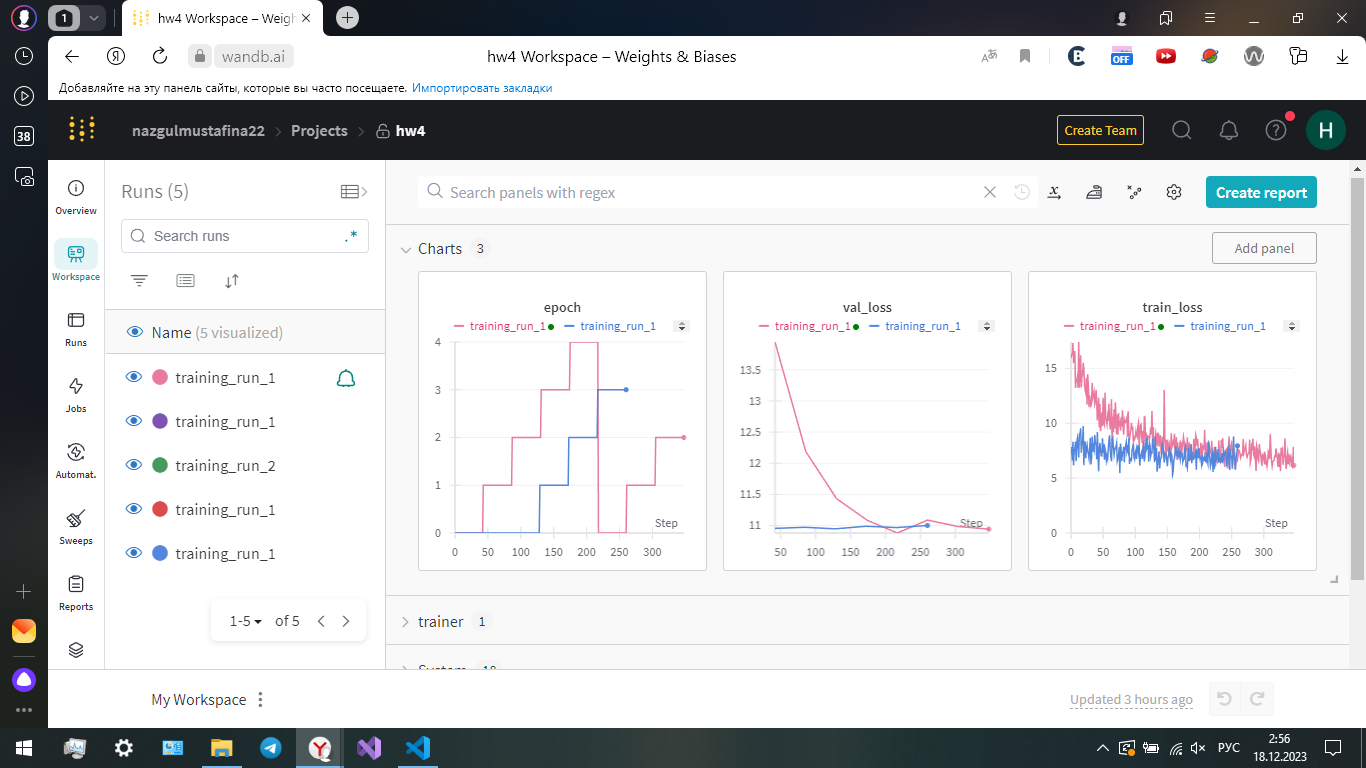

*Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?*

Получилось так, что ошибка на валидационной выборке при использовании сниппетов и правда ниже, но пришлось поставить побольше эпох.

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
#для модели без сниппетов
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

with torch.no_grad():
  for title, target in test_dataloader:
      logit = model_baseline(title)
      pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

In [ ]:
#для модели со сниппетами
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

with torch.no_grad():
  for title, snippet, target in test_dataloader:

      logit = model_baseline(title, snippet)
      pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9954967498779297
Precision: 0.29086464643478394
Recall: 0.7623748183250427


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983279705047607
Precision: 0.5204216837882996
Recall: 0.6148678660392761


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983178973197937
Precision: 0.005352840758860111
Recall: 0.004853079095482826


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    with torch.no_grad():
        for data in dataloader:
            if len(data) == 2:  # Если в данных только заголовок (title)
                title, target = data
                logit = model(title)
            else:  # Если в данных есть и заголовок, и сниппет (title, snippet)
                title, snippet, target = data
                logit = model(title, snippet)

            pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == len(dataset)
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ Мне кажется, что важнее в этой задаче полнота, так как кажется будто не так уж страшно, если будут некоторые неточности, зато больше людей узнают. Наверное, важнее минимизировать ложноотрицательные предсказания, чтобы как можно больше был охват. А вообще, лучше всего считать бы f1 меру, чтобы и то и то было на приемлемом уровне

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
# your code here
# (＠_＠)

In [ ]:
#Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
def find_optimal_threshold(model, dataset):
    pred_probs, targets = get_predict(model, dataset)
    thresholds = np.linspace(0, 1, 100)  # Генерируем 100 значений порога от 0 до 1
    best_recall = 0.0
    best_threshold = 0.0
    pred_probs = pred_probs
    targets = targets
    for threshold in thresholds:
        y_pred = 1*(pred_probs > threshold)
        # Вычисляем recall для каждого порога
        _recall = recall(targets, y_pred)

        # Обновляем лучший recall и соответствующий порог
        if _recall > best_recall:
            best_recall = _recall
            best_threshold = threshold

    return best_threshold

In [ ]:
#Подберите значение порога на валидационной выборке.
TRESHOLD = find_optimal_threshold(model_baseline, val_dataset)
TRESHOLD

0.0

In [ ]:
#Сравните модель без сниппетов
pred_probs, targets = get_predict(model_baseline, test_dataset)
y_pred = 1*(pred_probs > TRESHOLD)
print('Exact Match:', exact_match(targets, y_pred))
print('Precision:', precision(targets, y_pred))
print('Recall:', recall(targets, y_pred))

Exact Match: 0.0016850766260176897
Precision: 0.0016850765096023679
Recall: 0.9999951720237732


In [ ]:
#Модель со сниппетами
torch.cuda.empty_cache()
TRESHOLD = find_optimal_threshold(model_baseline, val_dataset)
pred_probs, targets = get_predict(model_baseline, test_dataset)
y_pred = 1*(pred_probs > TRESHOLD)
print('Exact Match:', exact_match(targets, y_pred))
print('Precision:', precision(targets, y_pred))
print('Recall:', recall(targets, y_pred))

Exact Match: 0.021296074613928795
Precision: 0.0017218419816344976
Recall: 0.9916775226593018


Какая из них оказалась лучше? Модель со сниппетами оказалась чуть лучше, немного просела в recall, зато по остальным метрикам чуть-чуть получше

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1413, 232]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1269, 1071]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1212, 1558]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[731]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[151, 1071]"


In [ ]:
TRESHOLD = 0.000001

In [ ]:
# your code here
# (❍ᴥ❍ʋ)
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
pred_probs, targets = get_predict(model_baseline, oob_dataset)
y_pred = 1*(pred_probs > TRESHOLD)
print('Exact Match:', exact_match(targets, y_pred))
print('Precision:', precision(targets, y_pred))
print('Recall:', recall(targets, y_pred))

Exact Match: 0.12026278674602509
Precision: 0.0018697748892009258
Recall: 0.9513525366783142


Проседает ли на ней качество модели? Насколько сильно?
Recall уменьшается, зато accuracy и precision становятся чуть выше

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__
Попыталась добавить как минимум сверточный слой conv1d, но так и не поняла, как оно работает, выдает ошибку о несовпадении размерностей.
Там и свертки с размером ядра побольше, дропаут, макспулингли, но ошибку исправить не удалось

-
-
-

In [ ]:
# your code here
# (⊙_⊙)
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=4096, kernel_size=3, padding = 1)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        conv1_out = F.relu(self.conv1(tf.keras.layers.GlobalMaxPooling1D(embedded)))
        pooled1 = F.max_pool1d(conv1_out, conv1_out.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled1), dim=1))
        cat = torch.cat((conv1_out), dim=1)
        output = self.fc(cat)
        return output
        # def __init__(self, vocab_size, embedding_dim, output_dim):
        #     super().__init__()
        #     self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #     self.fc = nn.Linear(embedding_dim * 2, output_dim)  # Умножаем embedding_dim на 2, так как у нас два входа: титул и сниппет

        # def forward(self, title, snippet):
        #     embedded_title = self.embedding(title)
        #     embedded_snippet = self.embedding(snippet)

        #     # Усредняем по текстам
        #     embedded_title = embedded_title.mean(dim=1)
        #     embedded_snippet = embedded_snippet.mean(dim=1)

        #     # Конкатенируем вектора
        #     combined = torch.cat((embedded_title, embedded_snippet), dim=1)
        #     return self.fc(combined)
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, 0.1)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)
wandb_logger = WandbLogger(log_model='all')
checkpoint_callback = ModelCheckpoint(
    dirpath = '/tmp/checkpoint',
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best_model')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
EPOCHS = 6
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
    max_epochs=EPOCHS,
    accelerator="gpu"
)

trainer.fit(train_module, train_dataloader, val_dataloader)

In [ ]:
# your code here
# (⊙_⊙)
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=4, padding = 1)
        self.conv3 = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=5, padding = 2)
        self.fc = nn.Linear(300, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)

        conv1_out = F.relu(self.conv1(embedded))
        conv2_out = F.relu(self.conv2(embedded))
        conv3_out = F.relu(self.conv3(embedded))

        pooled1 = F.max_pool1d(conv1_out, conv1_out.shape[2]).squeeze(2)
        pooled2 = F.max_pool1d(conv2_out, conv2_out.shape[2]).squeeze(2)
        pooled3 = F.max_pool1d(conv3_out, conv3_out.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled1, pooled2, pooled3), dim=1))
        cat = torch.cat((conv1_out, conv2_out, conv3_out), dim=1)
        output = self.fc(cat)
        return output
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, 0.1)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)
wandb_logger = WandbLogger(log_model='all')
checkpoint_callback = ModelCheckpoint(
    dirpath = '/tmp/checkpoint',
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best_model')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
EPOCHS = 6
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
    max_epochs=EPOCHS,
    accelerator="gpu"
)

trainer.fit(train_module, train_dataloader, val_dataloader)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNKN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNKN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNKN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNKN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN
...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNKN
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNKN
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNKN
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNKN


In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

pred_probs, targets = get_predict(model_baseline, vk_dataset)
y_pred = 1*(pred_probs > TRESHOLD)
print('Exact Match:', exact_match(targets, y_pred))
print('Precision:', precision(targets, y_pred))
print('Recall:', recall(targets, y_pred))
# your code here
# (っ˘ڡ˘ς)

Exact Match: 0.9983012080192566
Precision: 0.0003512623661663383
Recall: 0.0006523419287987053


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [29]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Установим библиотеку. 🤗🤗🤗

In [30]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline

# Загрузка модели
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")

# Прогонка комментариев через сентимент-классификатор
comments = df_comments['text'].tolist()

# Прогонка комментариев через сентимент-классификатор
results = model(comments)

for result in results:
    print(result)


In [ ]:
# your code here
# ʕ•ᴥ•ʔ

[{'label': 'positive', 'score': 0.9398769736289978}]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_vk['sentiment_verdict'] = ...
df_vk['sentiment_score'] = ...

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
# your code here
# [✖‿✖]

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
# your code here
# ฅ^•ﻌ•^ฅ

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ